In [27]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
import re
import torch
import requests
import time
import nltk
from nltk.corpus import words as nltk_words
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from torch.utils.data import Dataset
from torch.nn.functional import softmax
from wordcloud import WordCloud

In [28]:
# download NLTK data quietly
nltk.download('words', quiet=True)

True

In [29]:
# Data Ingestion via Steam API
def fetch_game_reviews(app_id, max_reviews=15000):
  """
  Fetches reviews for a given game ID from the Steam API.
  """
  url = f"https://store.steampowered.com/appreviews/{app_id}?json=1"
  reviews = []
  cursor = '*'
  params = {
      'filter': 'recent',
      'language': 'english',
      'day_range': 365,
      'review_type': 'all',
      'purchase_type': 'all',
      'num_per_page': 100
  }

  print(f"Fetching data for AppID: {app_id}.")

  pbar = tqdm(total=max_reviews)
  while len(reviews) < max_reviews:
    params['cursor'] = cursor
    try:
      response = requests.get(url, params=params)
      data = response.json()

      if 'reviews' not in data or not data['reviews']:
        break

      for r in data['reviews']:
        reviews.append({
            'review': r['review'],
            'recommend': 1 if r['voted_up'] else 0,
            'playtime': r['author']['playtime_forever'] / 60,
            'timestamp': r['timestamp_created']
        })
        pbar.update(1)

      cursor = data['cursor']
      time.sleep(0.5)

    except Exception as e:
      print(f"API Error: {e}")
      break
  pbar.close()
  return pd.DataFrame(reviews)

In [30]:
# fetch data for Overwatch 2 (App ID: 2357570)
df_final = fetch_game_reviews(2357570)
print(f"Total extracted records: {len(df_final)}")

Fetching data for AppID: 2357570.


15098it [02:14, 112.53it/s]                           

Total extracted records: 15098


In [31]:
# Data cleaning and prep
def clean_text(text: str) -> str:
  text = str(text).lower()
  text = re.sub(r"http\S+|www\S+", "", text) # URLs
  text = re.sub(r"[^a-z\s]", " ", text)      # keep letters/spaces
  text = re.sub(r"\b[a-z]\b", " ", text)     # single letters
  text = re.sub(r"(.)\1{2,}", r"\1", text)   # collapse repeats
  text = re.sub(r"\s+", " ", text).strip()   # whitespace
  return text

df_final['clean_review'] = df_final['review'].apply(clean_text)
df_final = df_final[df_final['clean_review'].str.len() > 10].reset_index(drop=True)

print(f"Rows after cleaning: {len(df_final)}")
print('\nLabel balance:')
print(df_final['recommend'].value_counts(normalize=True))

# split data
df_train, df_temp = train_test_split(df_final, test_size=0.2, random_state=23, stratify=df_final['recommend'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=23, stratify=df_temp['recommend'])

print(f"Train: {len(df_train):,} Val: {len(df_val):,} Test: {len(df_test):,}")

Rows after cleaning: 11196

Label balance:
recommend
0    0.536888
1    0.463112
Name: proportion, dtype: float64
Train: 8,956 Val: 1,120 Test: 1,120


In [32]:
# model setup
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_function(texts):
  return tokenizer(
      list(texts),
      padding=True,
      truncation=True,
      max_length=256,
      return_tensors='pt'
  )

train_encodings = tokenize_function(df_train['clean_review'])
val_encodings = tokenize_function(df_val['clean_review'])
test_encodings = tokenize_function(df_test['clean_review'])

y_train = torch.tensor(df_train['recommend'].values)
y_val = torch.tensor(df_val['recommend'].values)
y_test = torch.tensor(df_test['recommend'].values)

class SteamReviewsDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    item = {key: val[idx] for key, val in self.encodings.items()}
    item['labels'] = self.labels[idx]
    return item

train_dataset = SteamReviewsDataset(train_encodings, y_train)
val_dataset = SteamReviewsDataset(val_encodings, y_val)
test_dataset = SteamReviewsDataset(test_encodings, y_test)

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
      'f1': f1,
      'precision': precision,
      'recall': recall
  }

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    report_to='none',
    logging_steps=50,
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3364289175.py:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [33]:
# train and evaluate model

# train
trainer.train()

# evaluate
metrics = trainer.evaluate()
print(metrics)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.451600,0.434227,0.790179,0.780168,0.756806,0.805019
2,0.307000,0.415702,0.815179,0.794439,0.817996,0.772201
3,0.254300,0.460567,0.816964,0.796829,0.818737,0.776062


{'eval_loss': 0.4605673551559448, 'eval_accuracy': 0.8169642857142857, 'eval_f1': 0.796828543111992, 'eval_precision': 0.8187372708757638, 'eval_recall': 0.7760617760617761, 'eval_runtime': 7.7056, 'eval_samples_per_second': 145.349, 'eval_steps_per_second': 4.542, 'epoch': 3.0}


In [34]:
# save model locally
trainer.save_model('./final_model')
tokenizer.save_pretrained('./final_model')
print("Model saved to./final_model")

Model saved to./final_model


In [35]:
# evaluation and visualization

model.eval()
all_preds, all_probs, all_labels = [], [], []
loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

for batch in tqdm(loader, "Running Inference"):
  batch = {k: v.to(device) for k, v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)
    probs = softmax(outputs.logits, dim=-1)
    preds = torch.argmax(probs, dim=-1)

  all_preds.extend(preds.cpu().numpy())
  all_probs.extend(probs[:, 1].cpu().numpy())
  all_labels.extend(batch['labels'].cpu().numpy())

Running Inference: 100%|██████████| 35/35 [00:07<00:00,  4.41it/s]


<Figure size 600x400 with 0 Axes>

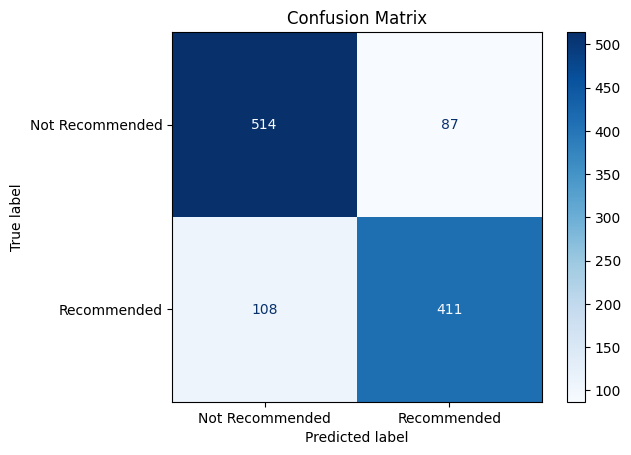

In [36]:
# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Recommended', 'Recommended'])
plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
plt.show()

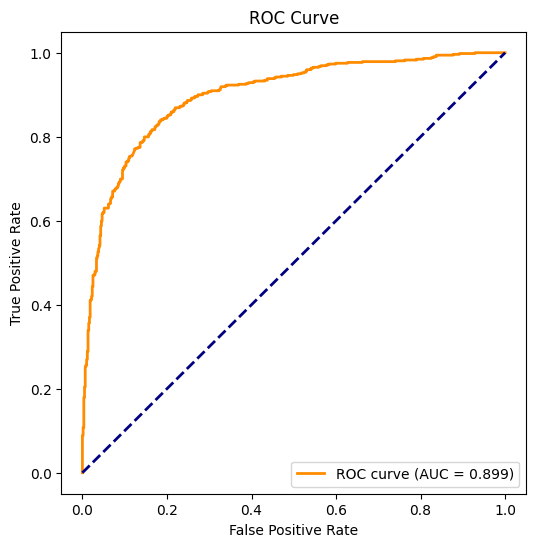

In [37]:
# ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()

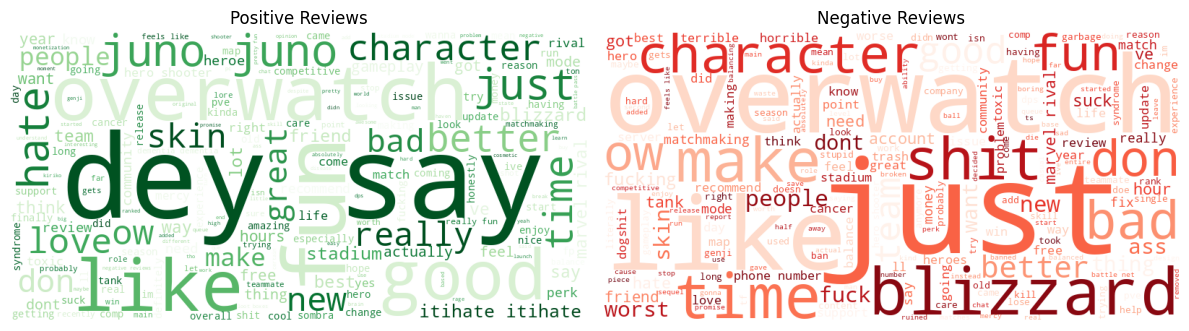

In [38]:
# word cloud
custom_stopwords = list(ENGLISH_STOP_WORDS.union({
    "game", "games", "player", "players", "play", "played", "playing",
    "steam", "dev", "devs", "developer", "developers"
}))
sample_for_keywords = df_final.sample(min(2000, len(df_final)), random_state=42)
pos_text = " ".join(sample_for_keywords.loc[sample_for_keywords["recommend"]==1, "clean_review"])
neg_text = " ".join(sample_for_keywords.loc[sample_for_keywords["recommend"]==0, "clean_review"])

wc_common = dict(width=800, height=400, background_color="white", stopwords=set(custom_stopwords))

if pos_text:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(WordCloud(**wc_common, colormap="Greens").generate(pos_text))
    plt.axis("off")
    plt.title("Positive Reviews")

if neg_text:
    plt.subplot(1, 2, 2)
    plt.imshow(WordCloud(**wc_common, colormap="Reds").generate(neg_text))
    plt.axis("off")
    plt.title("Negative Reviews")

plt.tight_layout()
plt.savefig("wordcloud.png")
plt.show()

In [39]:
print("Pipeline complete. Images saved.")

Pipeline complete. Images saved.
